<a href="https://colab.research.google.com/github/ochekroun/labs/blob/master/IFAGE_Cours_7_Introduction_%C3%A0_Deep_Q_network_(DQN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Préparation
---

Assurez-vous d'utiliser un GPU pour ce notebook ! (`GPU` sous `Runtime > Change runtime type > Hardware accelerator`)

In [ ]:
import sys

if 'google.colab' in sys.modules:
    !git clone https://github.com/MasterScrat/droneRL-workshop.git --single-branch
    !pip install -r "droneRL-workshop/colab-requirements.txt"
    import os
    os.kill(os.getpid(), 9)
    # Le Runtime va redémarrer après cette étape - c'est normal !

Cloning into 'droneRL-workshop'...
remote: Enumerating objects: 673, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 673 (delta 65), reused 71 (delta 25), pack-reused 543
Receiving objects: 100% (673/673), 22.60 MiB | 13.45 MiB/s, done.
Resolving deltas: 100% (391/391), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 13.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 61.1 MB/s

In [ ]:
%cd droneRL-workshop

/content/droneRL-workshop


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import os

In [ ]:
from env.env import DeliveryDrones
from env.wrappers import CompassQTable, LidarCompassQTable, LidarCompassChargeQTable, WindowedGridView
from agents.random import RandomAgent
from agents.qlearning import QLearningAgent
from agents.dqn import DQNAgent, DenseQNetworkFactory, ConvQNetworkFactory
from helpers.rl_helpers import MultiAgentTrainer, plot_rolling_rewards, test_agents, plot_cumulative_rewards, render_video, set_seed, ColabVideo

Premiers essais avec DQN
---

In [ ]:
# Create environment
env = LidarCompassChargeQTable(DeliveryDrones())
env.env_params.update({
    'n_drones': 3, 'pickup_reward': 0.99, 'delivery_reward': 1
})
states = env.reset()

# Create the agents
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents[0] = DQNAgent(
    env, DenseQNetworkFactory(env, hidden_layers=[256, 256]),
    gamma=0.95, epsilon_start=1, epsilon_decay=0.999, epsilon_end=0.01,
    memory_size=10000, batch_size=64, target_update_interval=5
)
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)
agents[0].qnetwork

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


DenseQNetwork(
  (network): Sequential(
    (dense_1): Linear(in_features=29, out_features=256, bias=True)
    (dense_act_1): ReLU()
    (dense_2): Linear(in_features=256, out_features=256, bias=True)
    (dense_act_2): ReLU()
    (dense_3): Linear(in_features=256, out_features=5, bias=True)
  )
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Training agents:   0%|                                                    | 0/2500 [00:00<?, ?it/s]/content/droneRL-workshop/agents/dqn.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  states_tensor = Tensor(states_flattened)
Training agents: 100%|█████████████████████████████████████████| 2500/2500 [00:29<00:00, 85.73it/s]


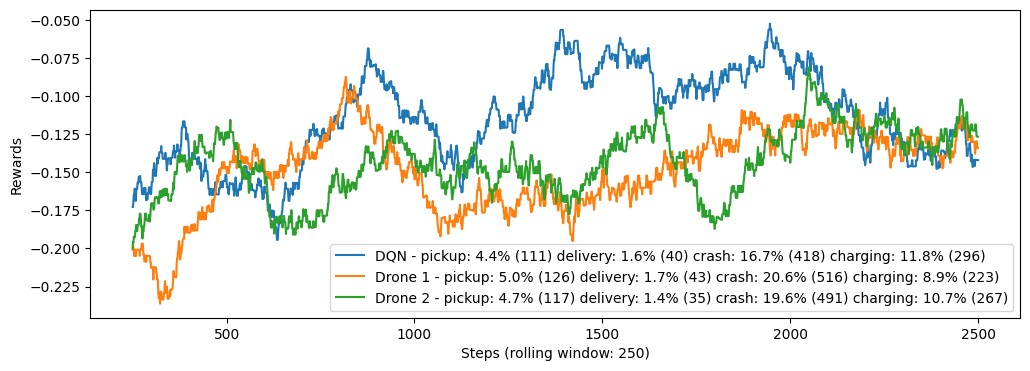

In [ ]:
# Train the agents
trainer.train(2500)
plot_rolling_rewards(
    trainer.rewards_log, drones_labels={0: 'DQN'},
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1], 'charging': [-0.1]})

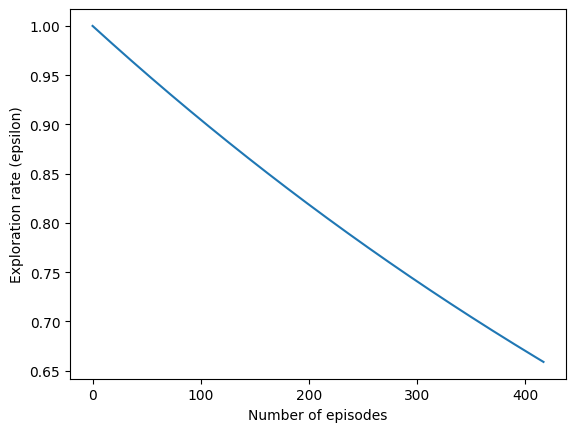

In [ ]:
plt.plot(agents[0].epsilons)
plt.xlabel('Number of episodes')
plt.ylabel('Exploration rate (epsilon)')
plt.show()

Essayez avec des `seed`s différentes !

/usr/local/lib/python3.10/dist-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
Testing agents: 100%|█████████████████████████████████████████| 1000/1000 [00:01<00:00, 660.22it/s]


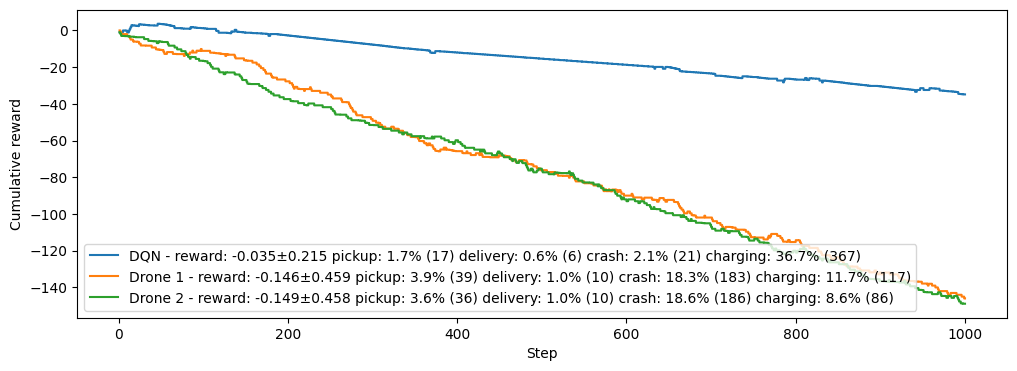

In [ ]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)
plot_cumulative_rewards(
    rewards_log, drones_labels={0: 'DQN'},
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1], 'charging': [-0.1]})

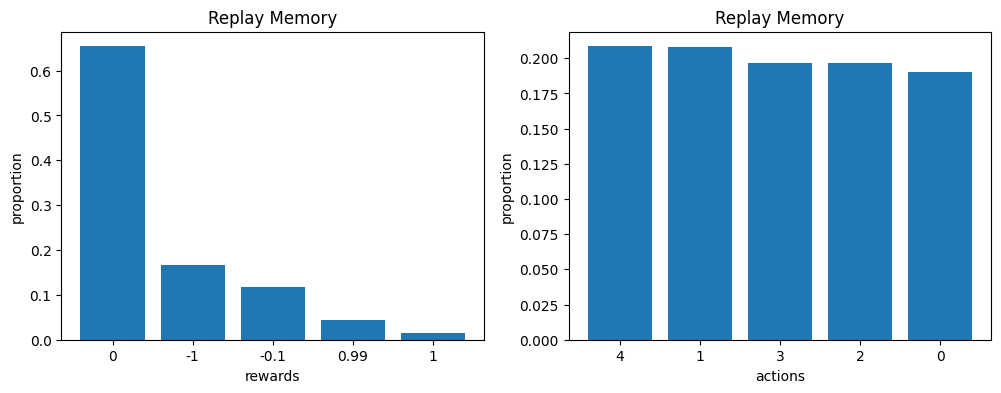

Top state:
 1) Count: 26 state: OrderedDict([('target_dir', 6), ('station_dir', 2), ('charge_level', 3), ('lidar..
 2) Count: 21 state: OrderedDict([('target_dir', 4), ('station_dir', 0), ('charge_level', 3), ('lidar..
 3) Count: 18 state: OrderedDict([('target_dir', 0), ('station_dir', 4), ('charge_level', 3), ('lidar..
 4) Count: 17 state: OrderedDict([('target_dir', 1), ('station_dir', 0), ('charge_level', 3), ('lidar..
 5) Count: 14 state: OrderedDict([('target_dir', 4), ('station_dir', 8), ('charge_level', 3), ('lidar..
 6) Count: 14 state: OrderedDict([('target_dir', 0), ('station_dir', 8), ('charge_level', 3), ('lidar..
 7) Count: 13 state: OrderedDict([('target_dir', 2), ('station_dir', 4), ('charge_level', 3), ('lidar..
 8) Count: 13 state: OrderedDict([('target_dir', 1), ('station_dir', 8), ('charge_level', 3), ('lidar..
 9) Count: 13 state: OrderedDict([('target_dir', 4), ('station_dir', 4), ('charge_level', 3), ('lidar..
10) Count: 13 state: OrderedDict([('target_dir', 3), 

In [ ]:
# Inspectons le "replay buffer"
agents[0].inspect_memory(top_n=10, max_col=80)

Essayer différentes valeurs pour les principaux paramètres : `memory_size`, `batch_size`, `target_update_interval`

In [ ]:
path = os.path.join('output', 'videos', 'dqn-compass-lidar-charge.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=0)
ColabVideo(path)

  from scipy.ndimage.filters import sobel

  deprecation(

t:   0%|                                                | 3/2880 [00:00<01:41, 28.32it/s, now=None]

Moviepy - Building video output/videos/dqn-compass-lidar-charge.mp4.
Moviepy - Writing video output/videos/dqn-compass-lidar-charge.mp4



Moviepy - Done !
Moviepy - video ready output/videos/dqn-compass-lidar-charge.mp4


DQN avec WindowedGrid
---

In [ ]:
from env.wrappers import WindowedGridView
from agents.dqn import ConvQNetworkFactory

# Création d'un environment compatible avec le challenge AIcrowd
env = WindowedGridView(DeliveryDrones(), radius=3)
env.env_params.update({
    'n_drones': 3,
    'pickup_reward': 0.99,
    'delivery_reward': 1
})
states = env.reset()

# Création des agents
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents[0] = DQNAgent(
    env,
    ConvQNetworkFactory(
        env,
        conv_layers=[
            {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
            {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
            {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
            {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1},
            {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1},
            {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1},
            {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        ],
        dense_layers=[
            1024, 256
        ]),
    gamma=0.95,
    epsilon_start=1,
    epsilon_decay=0.99,
    epsilon_end=0.01,
    memory_size=10000,
    batch_size=64,
    target_update_interval=5
)
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)
agents[0].qnetwork

  and should_run_async(code)



ConvQNetwork(
  (network): Sequential(
    (conv2d_1): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2d_act_1): ReLU()
    (conv2d_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2d_act_2): ReLU()
    (conv2d_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2d_act_3): ReLU()
    (conv2d_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2d_act_4): ReLU()
    (conv2d_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2d_act_5): ReLU()
    (conv2d_6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2d_act_6): ReLU()
    (conv2d_7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2d_act_7): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense_1): Linear(in_features=3136, out_features=1024, bias=True)
    (dense_act_1): ReLU()
    (dense_2): Linear(in_features=1024, out_features=25

Training agents: 100%|█████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.37it/s]


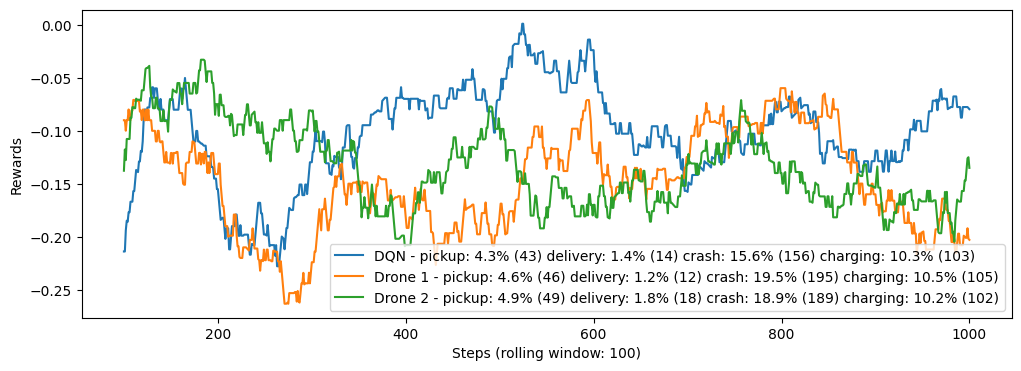

Training agents: 100%|█████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.16it/s]


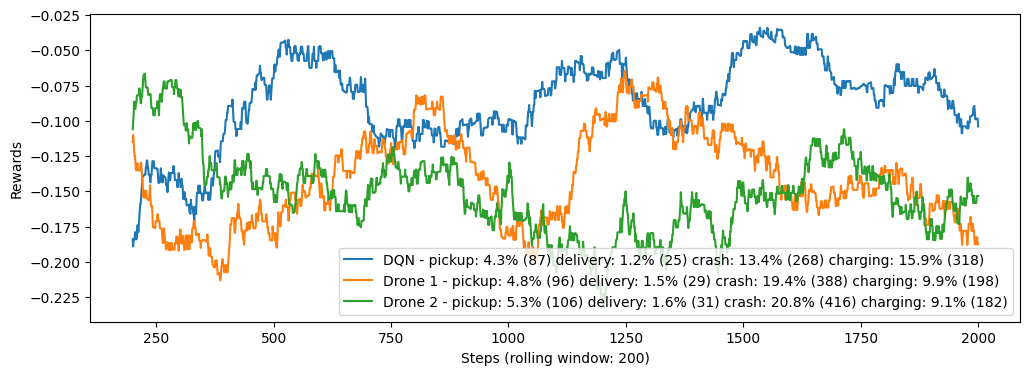

Training agents: 100%|█████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.59it/s]


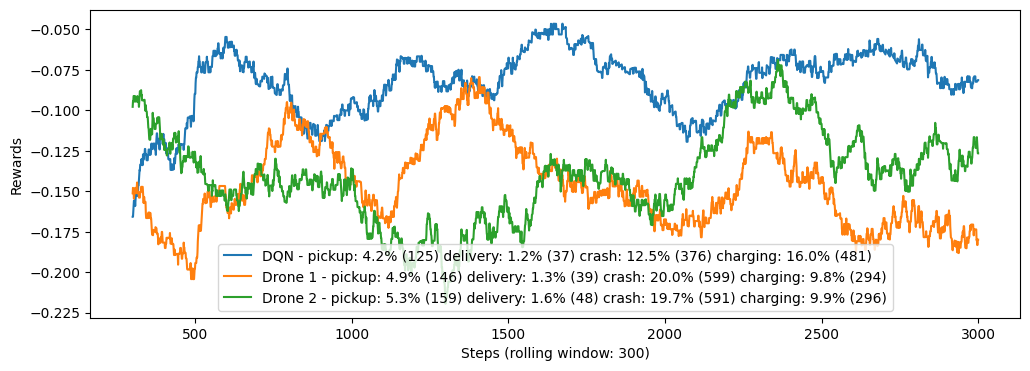

Training agents: 100%|█████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.55it/s]


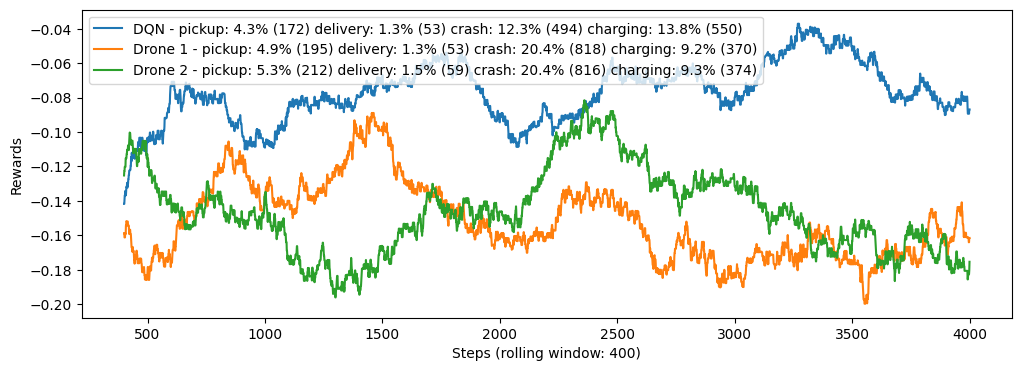

In [ ]:
# Entrainement
# on appelle trainer.train plusieurs fois pour changer d'environnement
for run in range(4):
  trainer.train(1000)
  plot_rolling_rewards(
      trainer.rewards_log, drones_labels={0: 'DQN'},
      events={'pickup': [0.99], 'delivery': [1], 'crash': [-1], 'charging': [-0.1]})

Testing agents: 100%|█████████████████████████████████████████| 1000/1000 [00:02<00:00, 481.86it/s]


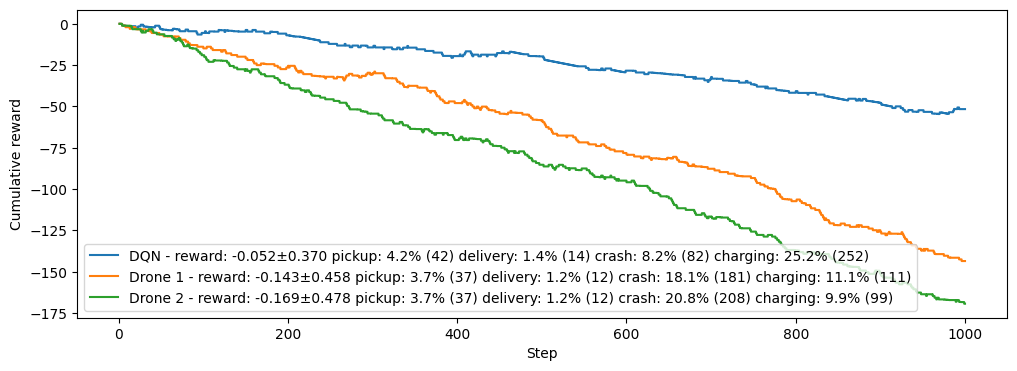

Final scores:
Agent 0: -51.620000000000005
Agent 1: -143.47
Agent 2: -169.27


In [ ]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)
plot_cumulative_rewards(
    rewards_log, drones_labels={0: 'DQN'},
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1], 'charging': [-0.1]})

# Notes finales (équivalentes à ce que mesure AIcrowd)
print('Final scores:')
for idx, score in enumerate(np.sum(list(rewards_log.values()), axis=1)):
    print("Agent {}: {}".format(idx, score))

In [ ]:
path = os.path.join('output', 'videos', 'dqn-windowed.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=0)
ColabVideo(path)

t:   2%|▋                                             | 45/2880 [00:00<00:06, 442.68it/s, now=None]

Moviepy - Building video output/videos/dqn-windowed.mp4.
Moviepy - Writing video output/videos/dqn-windowed.mp4



Moviepy - Done !
Moviepy - video ready output/videos/dqn-windowed.mp4


## Envoyez sur AIcrowd ! 🚀

> https://www.aicrowd.com/challenges/dronerl

In [ ]:
path = os.path.join('output', 'agents', 'dqn-agent.pt')
agents[0].save(path)
# agents[0].load(path) # pour charger le même agent plus tard